In [59]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import autograd.numpy as np2
from autograd import grad

ticker = "PETR4.SA"
start_date = "2015-01-01"
end_date = "2023-01-01"

dados = yf.download(ticker, start=start_date, end=end_date)

dados.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2015-01-02 00:00:00+00:00,3.004427,9.36,9.99,9.35,9.99,49559500
2015-01-05 00:00:00+00:00,2.747639,8.56,9.19,8.53,9.14,78385100
2015-01-06 00:00:00+00:00,2.657763,8.28,8.83,8.04,8.71,84723300
2015-01-07 00:00:00+00:00,2.782947,8.67,8.73,8.36,8.56,85531000
2015-01-08 00:00:00+00:00,2.962699,9.23,9.39,8.74,8.79,83306300


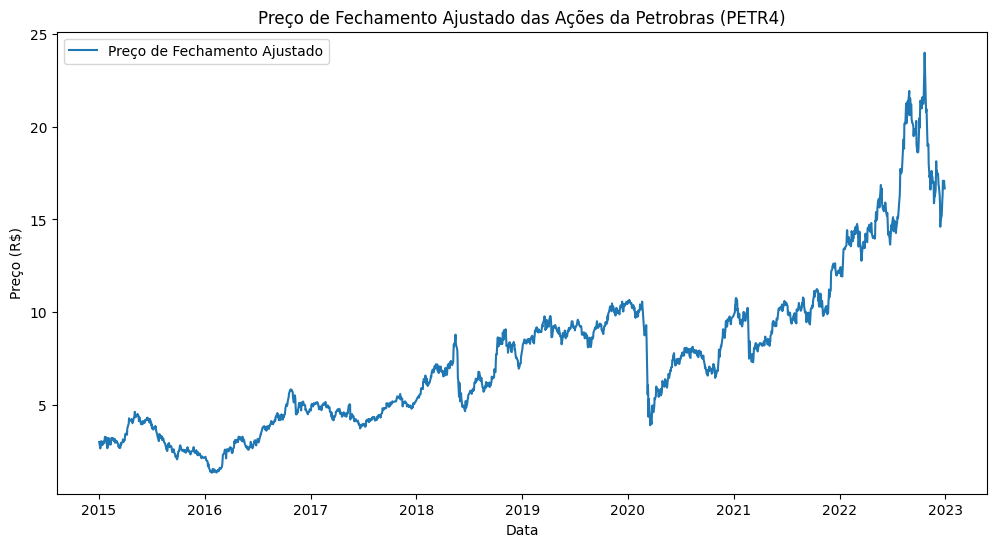

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(dados.index, dados['Adj Close'], label='Preço de Fechamento Ajustado')
plt.xlabel('Data')
plt.ylabel('Preço (R$)')
plt.title('Preço de Fechamento Ajustado das Ações da Petrobras (PETR4)')
plt.legend()
plt.show()

In [61]:
split_ratio = 0.7
split_index = int(len(dados) * split_ratio)

dados_treino = dados['Adj Close'][:split_index]
dados_teste = dados['Adj Close'][split_index:]

print(f"Tamanho dos dados de treino: {len(dados_treino)}")
print(f"Tamanho dos dados de teste: {len(dados_teste)}")

Tamanho dos dados de treino: 1391
Tamanho dos dados de teste: 597


In [62]:
def criar_janelas(series, k):
    X, y = [], []
    for i in range(k, len(series)):
        X.append(series[i-k:i])
        y.append(series[i])
    return np.array(X), np.array(y)

k = 5

X_treino, y_treino = criar_janelas(dados_treino.values, k)
X_teste, y_teste = criar_janelas(dados_teste.values, k)

print(f"Dimensões de X_treino: {X_treino.shape}")
print(f"Dimensões de y_treino: {y_treino.shape}")
print(f"Dimensões de X_teste: {X_teste.shape}")
print(f"Dimensões de y_teste: {y_teste.shape}")

Dimensões de X_treino: (1386, 5, 1)
Dimensões de y_treino: (1386, 1)
Dimensões de X_teste: (592, 5, 1)
Dimensões de y_teste: (592, 1)


In [63]:
def criar_janelas(series, k):
    X, y = [], []
    for i in range(k, len(series)):
        X.append(series[i-k:i])
        y.append(series[i])
    return np.array(X).reshape(-1, k), np.array(y)

X_treino, y_treino = criar_janelas(dados_treino.values, k)
X_teste, y_teste = criar_janelas(dados_teste.values, k)

w = np2.random.randn(k) * 0.01
learning_rate = 0.0001
num_epochs = 1000

def mse_loss(w, X, y):
    predictions = np2.dot(X, w)
    error = predictions - y
    return np2.mean(error ** 2)

gradient = grad(mse_loss)

for epoch in range(num_epochs):
    grad_w = gradient(w, X_treino, y_treino)
    w = w - learning_rate * grad_w
    
    if epoch % 100 == 0:
        loss = mse_loss(w, X_treino, y_treino)
        print(f"Época {epoch}, Erro de Treinamento (MSE): {loss:.4f}")

print("Treinamento concluído!")
print("Pesos finais:", w)

Época 0, Erro de Treinamento (MSE): 36.2393
Época 100, Erro de Treinamento (MSE): 11.0530
Época 200, Erro de Treinamento (MSE): 11.0425
Época 300, Erro de Treinamento (MSE): 11.0424
Época 400, Erro de Treinamento (MSE): 11.0424
Época 500, Erro de Treinamento (MSE): 11.0424
Época 600, Erro de Treinamento (MSE): 11.0424
Época 700, Erro de Treinamento (MSE): 11.0424
Época 800, Erro de Treinamento (MSE): 11.0424
Época 900, Erro de Treinamento (MSE): 11.0424
Treinamento concluído!
Pesos finais: [0.16751695 0.16407542 0.1735147  0.16974345 0.170139  ]


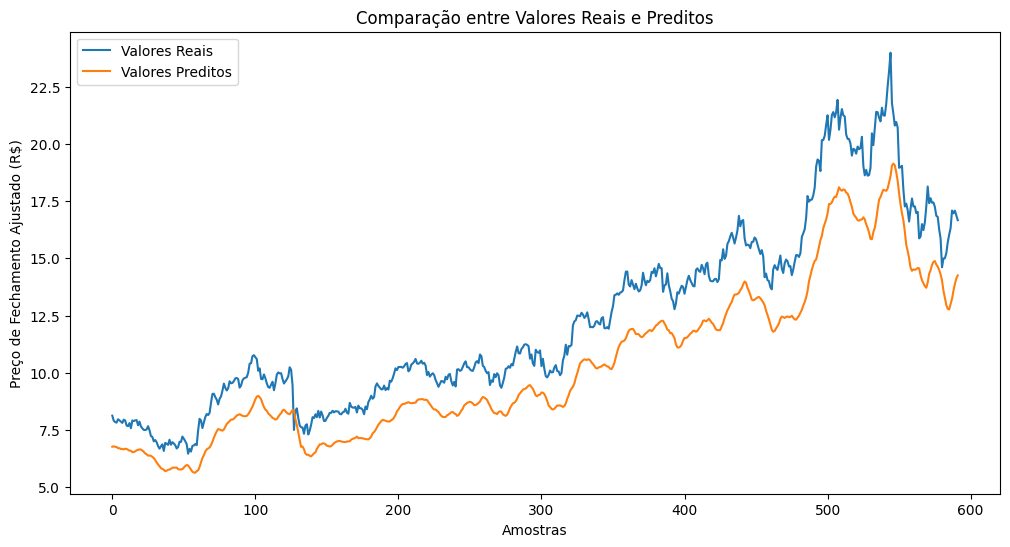

In [64]:
def prever(X, w):
    return np2.dot(X, w)

y_pred = prever(X_teste, w)

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_teste)), y_teste, label='Valores Reais')
plt.plot(range(len(y_pred)), y_pred, label='Valores Preditos')
plt.xlabel('Amostras')
plt.ylabel('Preço de Fechamento Ajustado (R$)')
plt.title('Comparação entre Valores Reais e Preditos')
plt.legend()
plt.show()

In [65]:
mae = np.mean(np.abs(y_teste - y_pred))
mse = np.mean((y_teste - y_pred) ** 2)

print(f"Erro Médio Absoluto (MAE) no Conjunto de Teste: {mae:.4f}")
print(f"Erro Quadrático Médio (MSE) no Conjunto de Teste: {mse:.4f}")

Erro Médio Absoluto (MAE) no Conjunto de Teste: 4.4382
Erro Quadrático Médio (MSE) no Conjunto de Teste: 31.6085


In [66]:
dados_semanal = dados['Adj Close'].resample('W').mean()
dados_mensal = dados['Adj Close'].resample('ME').mean()

def treino_avaliacao_escala(dados, k, learning_rate, num_epochs):
    dados_treino, dados_teste = dados[:int(len(dados) * 0.7)], dados[int(len(dados) * 0.7):]
    X_treino, y_treino = criar_janelas(dados_treino.values, k)
    X_teste, y_teste = criar_janelas(dados_teste.values, k)
    w = np2.random.randn(k) * 0.01
    gradient = grad(mse_loss)
    
    for epoch in range(num_epochs):
        grad_w = gradient(w, X_treino, y_treino)
        w = w - learning_rate * grad_w
    
    y_pred = prever(X_teste, w)
    mae = np.mean(np.abs(y_teste - y_pred))
    mse = np.mean((y_teste - y_pred) ** 2)
    
    return mae, mse, y_teste, y_pred

k = 5
learning_rate = 0.0001
num_epochs = 1000

mae_semanal, mse_semanal, y_teste_semanal, y_pred_semanal = treino_avaliacao_escala(dados_semanal, k, learning_rate, num_epochs)

mae_mensal, mse_mensal, y_teste_mensal, y_pred_mensal = treino_avaliacao_escala(dados_mensal, k, learning_rate, num_epochs)

print(f"Escala Semanal - MAE: {mae_semanal:.4f}, MSE: {mse_semanal:.4f}")
print(f"Escala Mensal - MAE: {mae_mensal:.4f}, MSE: {mse_mensal:.4f}")

Escala Semanal - MAE: 4.4365, MSE: 31.4390
Escala Mensal - MAE: 4.3065, MSE: 29.5687
